In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont 
import requests
import copy
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

/Users/sarathmenon/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import dataset

In [2]:
import torchvision
from torchvision import transforms

# Define the path to the COCO dataset
data_dir = '../datasets/label_studio_gen/coco_dataset/images'
annFile = '../datasets/label_studio_gen/coco_dataset/result.json'

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the COCO dataset
coco_dataset = torchvision.datasets.CocoDetection(root=data_dir, annFile=annFile, transform=transform)
class_labels = [cat['name'] for cat in coco_dataset.coco.cats.values()]
print(f"Dataset size: {len(coco_dataset)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dataset size: 45


### Plot ground truth segmentation

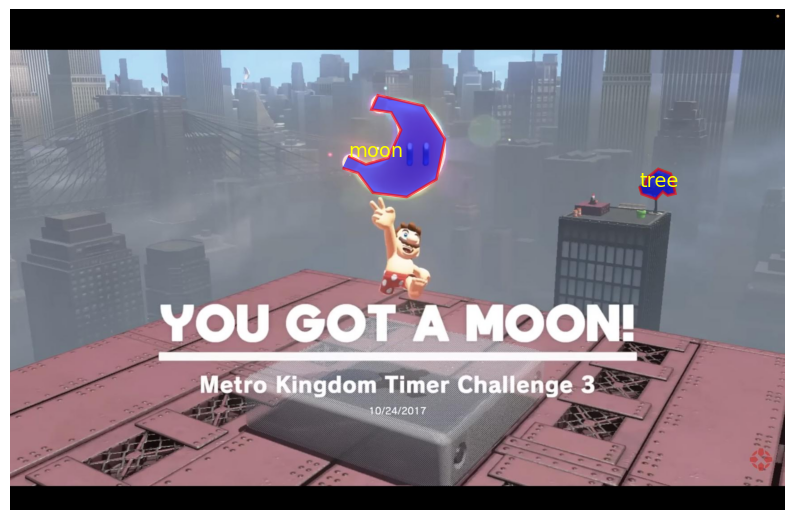

In [3]:
from matplotlib.path import Path
import matplotlib.patches as patches
import torch


def show(image, annotations, click_point=None):
    """
    Plots an image from the COCO dataset along with its segmentation map.

    Args:
    image (PIL Image): The image to plot.
    annotations (list):z A list of annotations, where each annotation is a dictionary containing 'segmentation' and other keys.
    """

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0)  # Transpose the image tensor

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()
    
    

    for annotation in annotations:
        # plot class label
        class_label = class_labels[annotation['category_id']]

        class_label_x = annotation['segmentation'][0][0]
        class_label_y = annotation['segmentation'][0][1] 
        plt.text(class_label_x, class_label_y, class_label, fontsize=14, color='yellow')

        # plot segmentation map
        for segmentation in annotation['segmentation']:
            poly = np.array(segmentation).reshape((len(segmentation) // 2, 2))
            poly_path = Path(poly)
            patch = patches.PathPatch(poly_path, facecolor='blue', edgecolor='red', linewidth=2, alpha=0.6)
            ax.add_patch(patch)

    if click_point:
        for point in click_point:
            color = 'yellow' if point['valid'] else 'red'
            shape = '*' if point['valid'] else 'x'
            plt.plot(point['x'], point['y'], shape, color=color, markersize=10)
    
    plt.axis('off')
    plt.grid(False)
    plt.show()

# Example usage:
index = 11
img, ground_truth_annotations = coco_dataset[index]
show(img, ground_truth_annotations)

### Check if predicted click point lies within the bounding boxes

In [10]:
from shapely.geometry import Point, Polygon

# create text input from labels
def create_text_input(annotations):
    labels = [class_labels[annotation['category_id']] for annotation in annotations]
    text_input = ""
    text_input = ". ".join(labels) + "." if labels else ""
    return text_input

def check_click_points(annotations, click_points):

    for annotation in annotations:
        class_label = class_labels[annotation['category_id']]
        
        # Filter click points matching the current class label
        matching_click_points = [cp for cp in click_points if cp['label'] == class_label]
        
        # Check if the click point is within the polygon of the annotation
        for click_point in matching_click_points:
            if check_point_in_polygon(annotation, click_point):
                # valid_click_points.append(click_point)
                click_point['valid'] = True
            else:
                print(f"Point lies outside the polygon for label: {class_label}")
                click_point['valid'] = False

        if len(matching_click_points) == 0:
            print(f"No click points found for label: {class_label}")

    return click_points
    
def check_point_in_polygon(annotation, click_point):
    point = Point(click_point['x'], click_point['y'])
    
    for segmentation in annotation['segmentation']:
        poly = np.array(segmentation).reshape((len(segmentation) // 2, 2))
        if Polygon(poly).contains(point):
            return True
    return False

def get_click_point(bboxes, labels):
    click_points = []
    for bbox, label in zip(bboxes, labels):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox

        # get geometric center of the bounding box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        click_points.append({'x': center_x, 'y': center_y, 'label': label})

    return click_points

import base64
import io
import requests

def get_model_prediction(image, text_input, task_prompt, url = "http://127.0.0.1:8082/detection"):
    # Convert PIL image to base64
    buffered = io.BytesIO()
    image.save(buffered, format="webp")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # Prepare JSON payload
    payload = {
        "image": img_str,
        "text_input": text_input,
        "task_prompt": task_prompt
    }

    # Make API call
    response = requests.get(url, json=payload)
    return response.json()

## Inference

text input: flag.
Inference time: 12.967540979385376


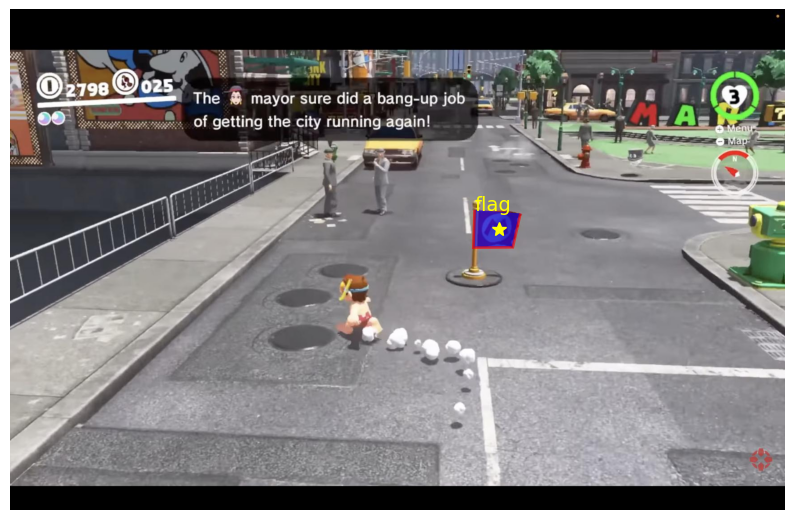

In [34]:
from torchvision import transforms

index = 5

image, annotations = coco_dataset[index]
text_input = create_text_input(annotations)
print(f"text input: {text_input}")

# convert pytorch tensor to PIL image
to_pil = transforms.ToPILImage()
image = to_pil(image.mul(255).byte())

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
# results = run_example(task_prompt, text_input=text_input)
# click_points = get_click_point(results['<CAPTION_TO_PHRASE_GROUNDING>'])

results = get_model_prediction(image, text_input, task_prompt)
click_points = get_click_point(results['bboxes'], results['labels'])
print(f"Inference time: {results['inference_time']} s")

click_points = check_click_points(annotations, click_points)
show(image, annotations, click_point=click_points)